# Разработка системы определения спам-писем
В современном цифровом мире электронная почта остаётся одним из основных средств общения. Однако вместе с её повсеместным использованием приходит и проблема спама — нежелательных сообщений, которые не только забивают наши почтовые ящики, но и могут представлять угрозу (фишинг, вредоносное ПО). Разработка эффективной системы автоматического определения спама является критически важной задачей для улучшения пользовательского опыта и обеспечения безопасности.

## Цель проекта:
Разработать и продемонстрировать полноценное решение для автоматической классификации электронных писем на "спам" и "не спам" с использованием методов машинного обучения.

# Как запустить приложение в Google Colab
1. Получите Ваш токен ngrok на сайте ngrok.com, где необходимо и зарегистрироваться (это важно и бесплато!).
2. Создайте секрет в Colab:
  * В поле "Имя" введите NGROK_AUTH_TOKEN (именно так, большими буквами).
  * В поле "Значение" вставьте токен ngrok.
  * "Доступ из блокнотов" должен быть включен.
3. Запустите все ячейки кода
4. В конце блокнота Вы увидите вывод, содержащий строку, которая начинается с **Ваше Streamlit-приложение доступно по ссылке: https://ваш_уникальный_адрес.ngrok-free.app.** Нажмите на эту ссылку.


In [3]:
# Импорты
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
import re
import string
import joblib

In [4]:
# Загрузка данных
path_to_directory = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

file_emails = "emails.csv"
path_to_emails_csv = os.path.join(path_to_directory, file_emails)
df = pd.read_csv(path_to_emails_csv)
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [7]:
# Предварительная обработка текстовых данных

# Функция для очистки текста
def clean_text(text):
    if text.startswith('Subject: '):
        text = text[text.find(' ')+1:]

    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'\[.*?\]', '', text)  # Удаление текста в квадратных скобках
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Удаление URL
    text = re.sub(r'<.*?>+', '', text)  # Удаление HTML-тегов
    text = ''.join([char for char in text if char not in string.punctuation])  # Удаление пунктуации
    text = re.sub(r'\n', '', text)  # Удаление символов новой строки
    text = re.sub(r'\w*\d\w*', '', text)  # Удаление слов, содержащих цифры
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов и обрезка
    return text


df['text_processed'] = df['text'].apply(clean_text)
df.head()

,text,spam,text_processed
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill ...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting to...
3,Subject: 4 color printing special request add...,1,color printing special request additional info...
4,"Subject: do not have money , get software cds ...",1,do not have money get software cds from here s...


In [8]:
# Разбиение данных на обучающую и тестовую выборки

X_raw_text = df['text_processed']
y = df['spam']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw_text, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Извлечение признаков (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000,
                                   min_df=5,
                                   max_df=0.7,
                                   stop_words='english',
                                   lowercase=True)

X_train = tfidf_vectorizer.fit_transform(X_train_raw)
X_test = tfidf_vectorizer.transform(X_test_raw)

In [10]:
# Обучение модели PassiveAggressiveClassifier
pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3)

pac_model.fit(X_train, y_train)

,C,1.0
,fit_intercept,True
,max_iter,1000
,tol,0.001
,early_stopping,False
,validation_fraction,0.1
,n_iter_no_change,5
,shuffle,True
,verbose,0
,loss,'hinge'
,n_jobs,None


In [11]:
# Оценка модели
y_pred = pac_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nТочность модели на тестовой выборке: {accuracy:.4f}")


Точность модели на тестовой выборке: 0.9921


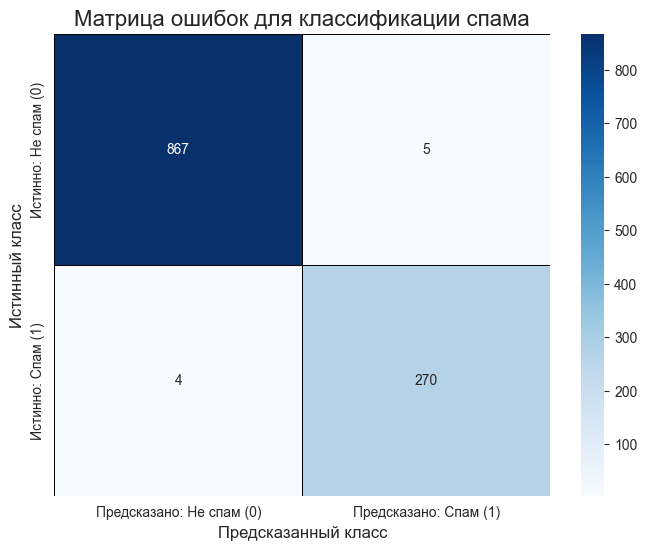

In [12]:
# Матрица ошибок (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,
            fmt='d',
            cmap='Blues',
            linewidths=.5,
            linecolor='black',
            xticklabels=['Предсказано: Не спам (0)', 'Предсказано: Спам (1)'],
            yticklabels=['Истинно: Не спам (0)', 'Истинно: Спам (1)'])

plt.title('Матрица ошибок для классификации спама', fontsize=16)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.show()

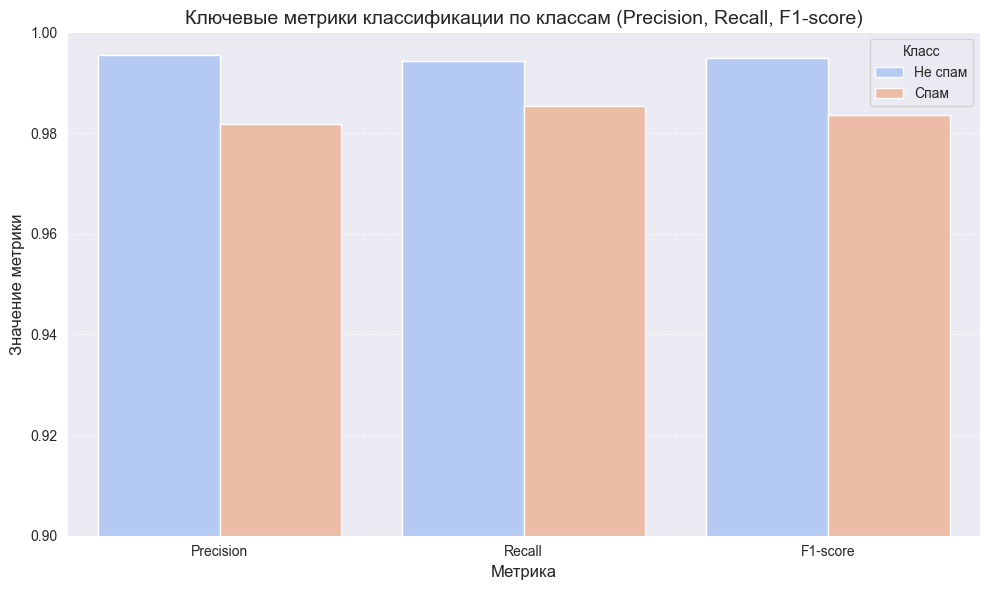

In [13]:
# Визуализация метрик Precision, Recall, F1-score по классам
classes_labels = ['Не спам', 'Спам']
class_report = classification_report(y_test, y_pred, target_names=classes_labels, output_dict=True)

precision_scores = [class_report[cls]['precision'] for cls in classes_labels]
recall_scores = [class_report[cls]['recall'] for cls in classes_labels]
f1_scores = [class_report[cls]['f1-score'] for cls in classes_labels]

metrics_df = pd.DataFrame({
    'Метрика': ['Precision', 'Recall', 'F1-score'],
    classes_labels[0]: [precision_scores[0], recall_scores[0], f1_scores[0]],
    classes_labels[1]: [precision_scores[1], recall_scores[1], f1_scores[1]]
})

metrics_df_melted = metrics_df.melt('Метрика', var_name='Класс', value_name='Значение')
plt.figure(figsize=(10, 6))
sns.barplot(x='Метрика', y='Значение', hue='Класс', data=metrics_df_melted, palette='coolwarm')
plt.ylim(0.9, 1.0)
plt.title('Ключевые метрики классификации по классам (Precision, Recall, F1-score)', fontsize=14)
plt.ylabel('Значение метрики', fontsize=12)
plt.xlabel('Метрика', fontsize=12)
plt.legend(title='Класс')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Визуализация общей точности
plt.figure(figsize=(4, 3))
plt.bar(['Общая Точность'], [accuracy], color='lightgreen')
plt.ylim(0.96, 1.0) # Ограничиваем ось Y для лучшей читаемости, так как точность высокая
plt.title(f'Общая точность модели: {accuracy:.2%}', fontsize=14)
plt.ylabel('Точность', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
# Сохранение обученной модели
model_path = 'spam_classifier_model.pkl'
vectorizer_path = 'tfidf_vectorizer.pkl'

joblib.dump(pac_model, model_path)
joblib.dump(tfidf_vectorizer, vectorizer_path)

['tfidf_vectorizer.pkl']